# 1 Data Cleaning

In [ ]:
bodyfat <- read.table('../data/BodyFat.csv',header = T,sep = ',')
options(repr.plot.width=4, repr.plot.height=4)
plot(bodyfat$BODYFAT,1/bodyfat$DENSITY,type = 'n',xlab="BODYFAT",ylab="DENSITY")
text(bodyfat$BODYFAT,1/bodyfat$DENSITY,bodyfat$IDNO,cex=0.5)
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
plot(bodyfat$ADIPOSITY,bodyfat$WEIGHT/bodyfat$HEIGHT^2,type = 'n',xlab="ADIPOSITY",ylab="WEIGHT/HEIGHT^2")
text(bodyfat$ADIPOSITY,bodyfat$WEIGHT/bodyfat$HEIGHT^2,bodyfat$IDNO,cex=0.5)
plot(bodyfat[-42,]$ADIPOSITY,bodyfat[-42,]$WEIGHT/bodyfat[-42,]$HEIGHT^2,type = 'n',xlab="ADIPOSITY",ylab="WEIGHT/HEIGHT^2")
text(bodyfat[-42,]$ADIPOSITY,bodyfat[-42,]$WEIGHT/bodyfat[-42,]$HEIGHT^2,bodyfat[-42,]$IDNO,cex=0.4)
bodyfat[42,'HEIGHT'] <- sqrt(bodyfat[42,'WEIGHT']/bodyfat[42,'ADIPOSITY']*703)
bodyfat[162,'HEIGHT'] <- sqrt(bodyfat[162,'WEIGHT']/bodyfat[162,'ADIPOSITY']*703) 
bodyfat[220,'HEIGHT'] <- sqrt(bodyfat[220,'WEIGHT']/bodyfat[220,'ADIPOSITY']*703) 
bodyfat[c(172,216),]
require("MVA")
require("biwt")
options(repr.plot.width=12, repr.plot.height=12)
pairs(bodyfat[-c(48,76,96,182),2:9], 
      panel = function(x,y, ...) {
        text(x, y, IDNO,cex = 1, pos = 2)
        bvbox(cbind(x,y), add = TRUE,method = "robust")
      })
options(repr.plot.width=12, repr.plot.height=12)
pairs(bodyfat[-c(48,76,96,182),10:17], 
      panel = function(x,y, ...) {
        text(x, y, IDNO,cex = 1, pos = 2)
        bvbox(cbind(x,y), add = TRUE,method = "robust")
      })
set.seed(2)
x <- sample(1:252,23)
y <- x[!x %in% c(48,76,96,182)]
options(repr.plot.width=6, repr.plot.height=6)
subdata <- bodyfat[unique(c(39,41,212,y)),c('IDNO',"ADIPOSITY","BODYFAT","CHEST","NECK",'HEIGHT','WRIST')]
stars(subdata[,c("ADIPOSITY","BODYFAT","CHEST","NECK",'HEIGHT','WRIST')],
      nrow=5,ncol=5,labels=subdata$IDNO)
options(repr.plot.width=6, repr.plot.height=6)
bodyfat$IDNO=NULL
lm.dirte <- lm(BODYFAT ~ ., data=subset(bodyfat[-c(39,41,48,76,96,182),],select=-DENSITY))
par(mfcol=c(2,2))
plot(lm.dirte)
write.csv(bodyfat,"../data/cleanfile.csv")

# 2 Model Selection
## 2.1 Variable selection

In [6]:
setwd("~/Desktop")
bodyfat.dat=read.csv("cleanfile.csv")

In [ ]:
library(leaps)
my.regsub <- function(matrix,y,nbest,method,nvmax=8){
  n<-length(y) #sample size
  k=(2:(nvmax+1)) #possible numbers of coefficients
  temp <- regsubsets(matrix,y,nbest=nbest,method=method,nvmax=nvmax)
  temp.mat <- cbind(summary(temp)$which,summary(temp)$cp,
                    n*log(2*pi)+n*log(summary(temp)$rss/(n-k))+n+k+2,
                    n*log(2*pi)+n*log(summary(temp)$rss/(n-k))+n-k+(k+1)*log(n),
                    1-summary(temp)$rss/sum((y-mean(y))^2))
  dimnames(temp.mat)[[2]] <- c(dimnames(summary(temp)$which)[[2]],
                               "cp", "aic", "bic","r_square")
  return(temp.mat)
}

regsub.mat<-my.regsub(bodyfat.dat[,-c(1,2)],bodyfat.dat$BODYFAT,nbest=1,method = "exhaustive")
options(repr.plot.width=2, repr.plot.height=2)
plot(regsub.mat[,"r_square"],type="b",
     main=bquote("Variable selection by"~R^2),
     xlab="Number of variables",
     ylab=expression(R^2),
     cex=0.5,pch=15
)

## 2.2 Cross Validation

In [ ]:
#choose 3 possible models and do cross validation on them
library(caret)
set.seed(2019)
train_control <- trainControl(method="cv", number=6)
model1 <- train(BODYFAT~WEIGHT+ABDOMEN,data=bodyfat.dat,trControl=train_control,method="lm",metric="RMSE")
model2 <- train(BODYFAT~WEIGHT+ABDOMEN+WRIST,data=bodyfat.dat,trControl=train_control,method="lm",metric="RMSE")
model3<- train(BODYFAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+FOREARM+WRIST,data=bodyfat.dat,
               trControl=train_control,method="lm",metric="RMSE")

## 2.3 Regression Diagnosis


Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = bodyfat.dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.9145 -2.8906 -0.4091  3.0001  9.2446 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -24.36041    6.25561  -3.894 0.000127 ***
WEIGHT       -0.08411    0.02248  -3.741 0.000229 ***
ABDOMEN       0.88522    0.05138  17.229  < 2e-16 ***
WRIST        -1.29158    0.40660  -3.177 0.001683 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.986 on 243 degrees of freedom
Multiple R-squared:  0.7344,	Adjusted R-squared:  0.7311 
F-statistic:   224 on 3 and 243 DF,  p-value: < 2.2e-16


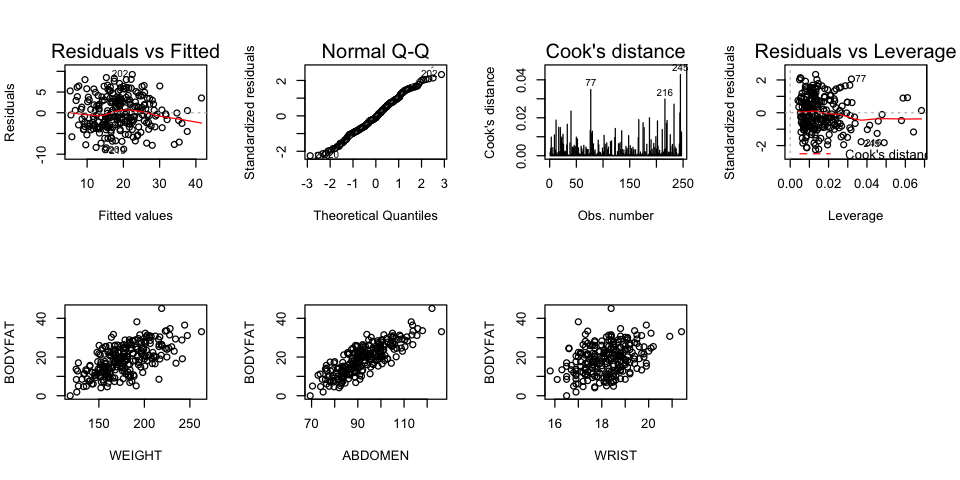

In [7]:
final.model <- lm(BODYFAT~WEIGHT + ABDOMEN + WRIST,data=bodyfat.dat)
summary(final.model)
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow = c(2,4))
plot(final.model, which = c(1,2,4,5))
plot(BODYFAT ~ WEIGHT, data=bodyfat.dat)
plot(BODYFAT ~ ABDOMEN, data=bodyfat.dat)
plot(BODYFAT ~ WRIST, data=bodyfat.dat)
#outlier
#sum(which(abs(rstudent(final.model))>2.576)) # 2.576 is the 0.01 quantial of N(0,1)
#high leverage point
#bodyfat.dat[unname(which(hatvalues(final.model)>2*4/dim(bodyfat.dat)[1])),c("BODYFAT","WEIGHT","ABDOMEN","WRIST")]
#summary(bodyfat.dat[c("WEIGHT","ABDOMEN","WRIST")])
#high influential point
#sum(which(cooks.distance(final.model)>0.5))

## Contribution:
    Data Cleaning: Jingwen Yan, Runfeng Yong, Chenghui Li
    Variable Selection: Jingwen Yan, Wenbo Fei
    Regression Diagnosis: Wenbo Fei
    Shiny App: Chenghui Li
    Comparison with online Calculator: Runfeng Yong
## Reference:
    1. Jung, Y., 2017. Multiple predicting K-fold cross-validation for model selection. Journal of Nonparametric Statistics, pp.1-19
    2. https://www.uspharmacist.com/article/belly-fat-in-men